# Getting images from PDF files and text descriptions with Azure Computer Vision

In [1]:
import datetime
import fitz
import glob
import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sys

from dotenv import load_dotenv
from pprint import pprint
from PIL import Image

In [2]:
print('Today is:', datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S'))

Today is: 21-Sep-2023 08:39:18


In [3]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

## PDF File

In [4]:
file = "paris_journal.pdf"

In [5]:
output_dir = "extracted_images"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Running the images extraction from the PDF

In [6]:
# Desired output image format
output_format = "png"

# Minimum width and height for extracted images
min_width = 100
min_height = 100

In [7]:
# open the file
pdf_file = fitz.open(file)

# Iterate over PDF pages
for page_index in range(len(pdf_file)):
    # Get the page itself
    page = pdf_file[page_index]
    # Get image list
    image_list = page.get_images(full=True)

    # Iterate over the images on the page
    for image_index, img in enumerate(image_list, start=1):
        # Get the XREF of the image
        xref = img[0]
        # Extract the image bytes
        base_image = pdf_file.extract_image(xref)
        image_bytes = base_image["image"]

        # Load it to PIL
        image = Image.open(io.BytesIO(image_bytes))

        # Check if the image meets the minimum dimensions and save it
        if image.width >= min_width and image.height >= min_height:
            image.save(
                open(
                    os.path.join(
                        output_dir,
                        f"image_from_page_{page_index + 1}_id_{image_index}.{output_format}",
                    ),
                    "wb",
                ),
                format=output_format.upper(),
            )

In [8]:
!ls $output_dir/*.* -lh

-rwxrwxrwx 1 root root 407K Sep 21 08:39 extracted_images/image_from_page_10_id_1.png
-rwxrwxrwx 1 root root 301K Sep 21 08:39 extracted_images/image_from_page_11_id_1.png
-rwxrwxrwx 1 root root 446K Sep 21 08:39 extracted_images/image_from_page_12_id_1.png
-rwxrwxrwx 1 root root 633K Sep 21 08:39 extracted_images/image_from_page_13_id_1.png
-rwxrwxrwx 1 root root 409K Sep 21 08:39 extracted_images/image_from_page_13_id_2.png
-rwxrwxrwx 1 root root 382K Sep 21 08:39 extracted_images/image_from_page_14_id_1.png
-rwxrwxrwx 1 root root 113K Sep 21 08:39 extracted_images/image_from_page_14_id_2.png
-rwxrwxrwx 1 root root  91K Sep 21 08:39 extracted_images/image_from_page_14_id_3.png
-rwxrwxrwx 1 root root 599K Sep 21 08:39 extracted_images/image_from_page_15_id_1.png
-rwxrwxrwx 1 root root 130K Sep 21 08:39 extracted_images/image_from_page_15_id_2.png
-rwxrwxrwx 1 root root 3.1M Sep 21 08:39 extracted_images/image_from_page_16_id_1.png
-rwxrwxrwx 1 root root 1.3M Sep 21 08:39 extracted_ima

In [9]:
def multiple_images(images_list, num_cols=2):
    """
    Display multiple images
    """
    num_rows = int(len(images_list) / num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_list):
            image = plt.imread(images_list[idx])
            ax.imshow(image)
            ax.set_title(images_list[idx])
            ax.axis("off")

        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
images_list = glob.glob(output_dir + "/*.png")

In [11]:
images_list

['extracted_images/image_from_page_10_id_1.png',
 'extracted_images/image_from_page_11_id_1.png',
 'extracted_images/image_from_page_12_id_1.png',
 'extracted_images/image_from_page_13_id_1.png',
 'extracted_images/image_from_page_13_id_2.png',
 'extracted_images/image_from_page_14_id_1.png',
 'extracted_images/image_from_page_14_id_2.png',
 'extracted_images/image_from_page_14_id_3.png',
 'extracted_images/image_from_page_15_id_1.png',
 'extracted_images/image_from_page_15_id_2.png',
 'extracted_images/image_from_page_16_id_1.png',
 'extracted_images/image_from_page_17_id_1.png',
 'extracted_images/image_from_page_18_id_1.png',
 'extracted_images/image_from_page_19_id_1.png',
 'extracted_images/image_from_page_19_id_2.png',
 'extracted_images/image_from_page_1_id_1.png',
 'extracted_images/image_from_page_20_id_1.png',
 'extracted_images/image_from_page_21_id_1.png',
 'extracted_images/image_from_page_21_id_2.png',
 'extracted_images/image_from_page_22_id_1.png',
 'extracted_images/im

## We can analyse the extracted image with Azure Computer Vision

In [12]:
load_dotenv("azure.env")

AZURE_CV_ENDPOINT = os.getenv("AZURE_CV_ENDPOINT")
AZURE_CV_API_KEY = os.getenv("AZURE_CV_API_KEY")

In [13]:
options = "&features=tags,objects,caption,read,smartCrops,denseCaptions,people"
model = "?api-version=2023-02-01-preview&modelVersion=latest"

url = AZURE_CV_ENDPOINT + "/computervision/imageanalysis:analyze" + model + options

headers = {
    "Content-type": "application/octet-stream",
    "Ocp-Apim-Subscription-Key": AZURE_CV_API_KEY,
}

### Test 1

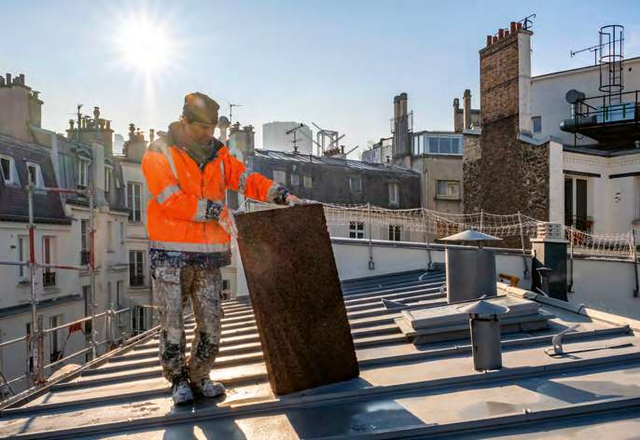

In [14]:
image_file = images_list[2]

img = Image.open(image_file)
img.thumbnail((640, 640), Image.LANCZOS)
img

### All results from the image

In [15]:
with open(image_file, "rb") as f:
    data = f.read()

r = requests.post(url, data=data, headers=headers)
pprint(r.json())

{'captionResult': {'confidence': 0.6781039834022522,
                   'text': 'a man in an orange jacket and hat standing on a '
                           'roof'},
 'denseCaptionsResult': {'values': [{'boundingBox': {'h': 472,
                                                     'w': 686,
                                                     'x': 0,
                                                     'y': 0},
                                     'confidence': 0.6781039834022522,
                                     'text': 'a man in an orange jacket and '
                                             'hat standing on a roof'},
                                    {'boundingBox': {'h': 342,
                                                     'w': 174,
                                                     'x': 151,
                                                     'y': 98},
                                     'confidence': 0.6497090458869934,
                                     'te

In [16]:
caption = r.json()["captionResult"]
pprint(caption)

{'confidence': 0.6781039834022522,
 'text': 'a man in an orange jacket and hat standing on a roof'}


In [17]:
tags = r.json()["tagsResult"]
pprint(tags)

{'values': [{'confidence': 0.995599627494812, 'name': 'outdoor'},
            {'confidence': 0.9946223497390747, 'name': 'clothing'},
            {'confidence': 0.9853844046592712, 'name': 'sky'},
            {'confidence': 0.9847864508628845, 'name': 'building'},
            {'confidence': 0.9768338203430176, 'name': 'person'},
            {'confidence': 0.8937499523162842, 'name': 'footwear'},
            {'confidence': 0.8488559722900391, 'name': 'man'},
            {'confidence': 0.8268591165542603, 'name': 'construction'},
            {'confidence': 0.6627939939498901, 'name': 'ground'},
            {'confidence': 0.5990528464317322, 'name': 'city'},
            {'confidence': 0.553246021270752, 'name': 'street'}]}


### Test 2

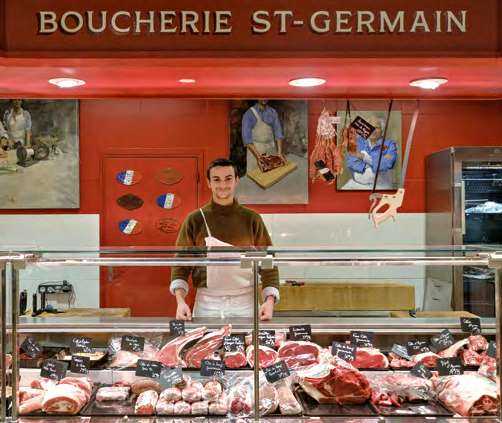

In [18]:
image_file = images_list[30]

img = Image.open(image_file)
img.thumbnail((640, 640), Image.LANCZOS)
img

In [19]:
with open(image_file, "rb") as f:
    data = f.read()

r = requests.post(url, data=data, headers=headers)
pprint(r.json())

{'captionResult': {'confidence': 0.8101101517677307,
                   'text': 'a man standing behind a display case of meat'},
 'denseCaptionsResult': {'values': [{'boundingBox': {'h': 423,
                                                     'w': 502,
                                                     'x': 0,
                                                     'y': 0},
                                     'confidence': 0.810059130191803,
                                     'text': 'a man standing behind a display '
                                             'case of meat'},
                                    {'boundingBox': {'h': 164,
                                                     'w': 113,
                                                     'x': 164,
                                                     'y': 153},
                                     'confidence': 0.6993224620819092,
                                     'text': 'a man standing behind a glass '
        

In [20]:
caption = r.json()["captionResult"]
pprint(caption)

{'confidence': 0.8101101517677307,
 'text': 'a man standing behind a display case of meat'}


In [21]:
densecaptions = r.json()["denseCaptionsResult"]
pprint(densecaptions)

{'values': [{'boundingBox': {'h': 423, 'w': 502, 'x': 0, 'y': 0},
             'confidence': 0.810059130191803,
             'text': 'a man standing behind a display case of meat'},
            {'boundingBox': {'h': 164, 'w': 113, 'x': 164, 'y': 153},
             'confidence': 0.6993224620819092,
             'text': 'a man standing behind a glass case'},
            {'boundingBox': {'h': 99, 'w': 492, 'x': 0, 'y': 317},
             'confidence': 0.680335521697998,
             'text': 'a display case with meat'},
            {'boundingBox': {'h': 178, 'w': 77, 'x': 422, 'y': 143},
             'confidence': 0.6922551989555359,
             'text': 'a blurry image of a car'},
            {'boundingBox': {'h': 165, 'w': 110, 'x': 94, 'y': 145},
             'confidence': 0.6424983143806458,
             'text': 'a person standing behind a glass case'},
            {'boundingBox': {'h': 97, 'w': 106, 'x': 305, 'y': 97},
             'confidence': 0.8090733289718628,
             'text'

In [22]:
tags = r.json()["tagsResult"]
pprint(tags)

{'values': [{'confidence': 0.8844553232192993, 'name': 'slaughterhouse'},
            {'confidence': 0.8619081974029541, 'name': 'food'},
            {'confidence': 0.7181278467178345, 'name': 'person'},
            {'confidence': 0.701615035533905, 'name': 'indoor'}]}


In [23]:
print(r.json()["readResult"]["content"])

BOUCHERIE ST-GERMAIN


In [24]:
densecaptions = r.json()["denseCaptionsResult"]
pprint(densecaptions)

{'values': [{'boundingBox': {'h': 423, 'w': 502, 'x': 0, 'y': 0},
             'confidence': 0.810059130191803,
             'text': 'a man standing behind a display case of meat'},
            {'boundingBox': {'h': 164, 'w': 113, 'x': 164, 'y': 153},
             'confidence': 0.6993224620819092,
             'text': 'a man standing behind a glass case'},
            {'boundingBox': {'h': 99, 'w': 492, 'x': 0, 'y': 317},
             'confidence': 0.680335521697998,
             'text': 'a display case with meat'},
            {'boundingBox': {'h': 178, 'w': 77, 'x': 422, 'y': 143},
             'confidence': 0.6922551989555359,
             'text': 'a blurry image of a car'},
            {'boundingBox': {'h': 165, 'w': 110, 'x': 94, 'y': 145},
             'confidence': 0.6424983143806458,
             'text': 'a person standing behind a glass case'},
            {'boundingBox': {'h': 97, 'w': 106, 'x': 305, 'y': 97},
             'confidence': 0.8090733289718628,
             'text'

## Getting captions from all the extracted images

In [25]:
df = pd.DataFrame(
    columns=[
        "image_file",
        "image_caption",
        "caption_confidence",
        "ocr",
        "tags",
        "dense_captions",
    ]
)

captions_list = []
files_list = []
confidences_list = []
ocr_list = []
tags_list = []
tags_list2 = []
dc_list = []
dc_list2 = []

for i in range(len(images_list)):
    with open(images_list[i], "rb") as f:
        print("Getting caption from:", images_list[i])
        # Reading the image
        data = f.read()
        # Call the Azure CV service
        r = requests.post(url, data=data, headers=headers)
        # Get caption
        caption = r.json()["captionResult"]["text"]
        confidence = r.json()["captionResult"]["confidence"]
        # Get OCR
        ocr = r.json()["readResult"]["content"]
        # Get the tags
        tags = r.json()["tagsResult"]["values"]
        tags_list = [tag["name"] for tag in tags]
        # Get the dense captions
        densecaptions = r.json()["denseCaptionsResult"]["values"]
        dc_list = [dc["text"] for dc in densecaptions]

        # Append to the lists
        files_list.append(images_list[i])
        captions_list.append(caption)
        confidences_list.append(confidence)
        ocr_list.append(ocr)
        tags_list2.append(",".join(tags_list))
        dc_list2.append(",".join(dc_list))

# Saving all into a df
df["image_file"] = files_list
df["image_caption"] = captions_list
df["caption_confidence"] = confidences_list
df["ocr"] = ocr_list
df["tags"] = tags_list2
df["dense_captions"] = dc_list2

print("\nDone")

Getting caption from: extracted_images/image_from_page_10_id_1.png
Getting caption from: extracted_images/image_from_page_11_id_1.png
Getting caption from: extracted_images/image_from_page_12_id_1.png
Getting caption from: extracted_images/image_from_page_13_id_1.png
Getting caption from: extracted_images/image_from_page_13_id_2.png
Getting caption from: extracted_images/image_from_page_14_id_1.png
Getting caption from: extracted_images/image_from_page_14_id_2.png
Getting caption from: extracted_images/image_from_page_14_id_3.png
Getting caption from: extracted_images/image_from_page_15_id_1.png
Getting caption from: extracted_images/image_from_page_15_id_2.png
Getting caption from: extracted_images/image_from_page_16_id_1.png
Getting caption from: extracted_images/image_from_page_17_id_1.png
Getting caption from: extracted_images/image_from_page_18_id_1.png
Getting caption from: extracted_images/image_from_page_19_id_1.png
Getting caption from: extracted_images/image_from_page_19_id_2

### We can use the captions with Azure Open AI and load them in an Azure Cognitive Search index

In [26]:
df.head(5)

,image_file,image_caption,caption_confidence,ocr,tags,dense_captions
0,extracted_images/image_from_page_10_id_1.png,a man in a black tank top and shorts kicking u...,0.661429,,"dance,person,clothing,dancing,sport",a man in a black tank top and shorts kicking u...
1,extracted_images/image_from_page_11_id_1.png,a man in shorts and a black shirt,0.698310,,"person,dance,clothing,dancing","a man in shorts and a black shirt,a man in sho..."
2,extracted_images/image_from_page_12_id_1.png,a man in an orange jacket and hat standing on ...,0.678449,,"outdoor,clothing,sky,building,person,footwear,...",a man in an orange jacket and hat standing on ...
3,extracted_images/image_from_page_13_id_1.png,a courtyard of a building,0.693753,,"outdoor,window,city,sky,apartment,neighbourhoo...","a courtyard of a building,a green bush in fron..."
4,extracted_images/image_from_page_13_id_2.png,a white building with plants and trees,0.635338,,"outdoor,building,window,apartment,sky,mixed-us...","a white building with plants and trees,a white..."


In [27]:
df.shape

(57, 6)

In [28]:
df.dtypes

image_file             object
image_caption          object
caption_confidence    float64
ocr                    object
tags                   object
dense_captions         object
dtype: object